### Reading in Data and Graphs

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
! pip install openpyxl

In [2]:
# reading in all the csv files
file = pd.ExcelFile(r"C:\Users\asus\Desktop\Data_sets\Supply chain logisitcs problem.xlsx")

plant_ports = file.parse("PlantPorts")

order_list = file.parse("OrderList")

products_plants = file.parse("ProductsPerPlant")

vmi_plants = file.parse("VmiCustomers")

freight_rates = file.parse("FreightRates")

wh_cost = file.parse("WhCosts")


# changing column names
order_list.columns = [i.replace(" ", "_") for i in order_list.columns]

products_plants.columns = [i.replace(" ", "_") for i in products_plants.columns]

plant_ports.columns = [i.replace(" ", "_") for i in plant_ports.columns]

vmi_plants.columns = [i.replace(" ", "_") for i in vmi_plants.columns]

wh_cost.set_index("WH", inplace = True)

In [3]:
plant_ports_graph = nx.from_pandas_edgelist(plant_ports, source = "Plant_Code", target = "Port")

### Supply Chain Mapping: 

#### Non Interactive with Networks

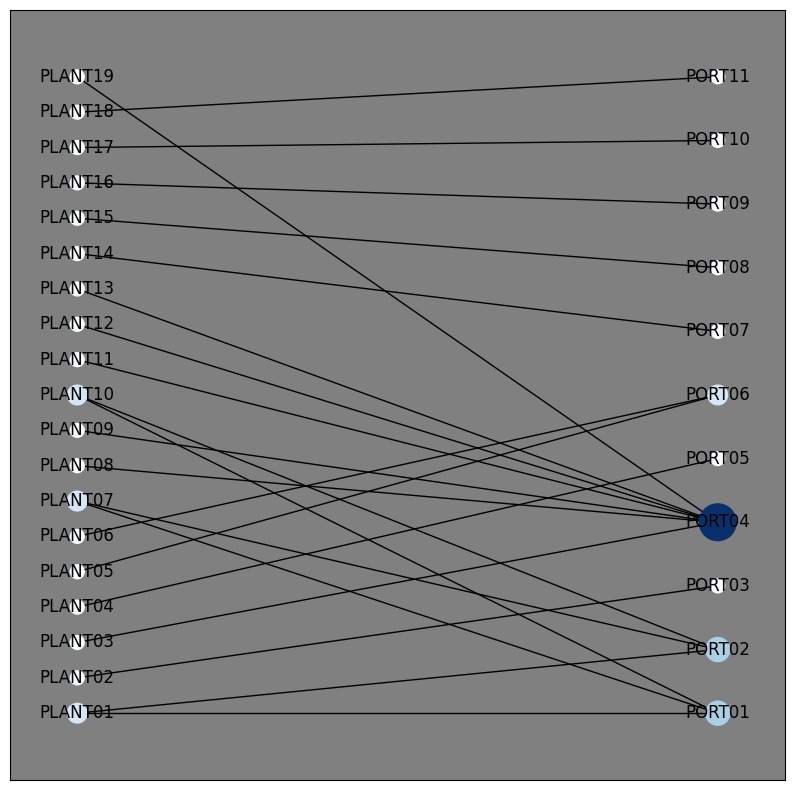

In [4]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_facecolor("Grey")

# specify layoyut of the graph
layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

for i in layout:
    if i.startswith("PLANT"):
        layout[i][0] -= 0.1
    else:
        layout[i][0] += 0.1
        
        
# we want to map the degree of the node to a color/size
degrees = dict(plant_ports_graph.degree)
maps = [v*100 for v in degrees.values()]


# specify the color map
cmap = plt.cm.Blues

# keyword args that are the same for both functions
kwargs = {"pos": layout, "ax": ax}

nx.draw_networkx_nodes(plant_ports_graph, node_size = maps, node_color = maps, cmap = cmap, **kwargs)
nx.draw_networkx_edges(plant_ports_graph, **kwargs)
nx.draw_networkx_labels(plant_ports_graph, pos = layout)
plt.show()

#### Interactive Version with Plotly

In [5]:
# get starting and ending points of the edges and add them to tha graph
layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

edge_x = []
edge_y = []

for edge in plant_ports_graph.edges():
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_trace = go.Scatter(x = edge_x, y = edge_y, line = dict(width = 0.5, color = '#25488e'), hoverinfo = 'none', mode = 'lines')

In [6]:
# get cooerdinated of nodes and add them to the graph

node_x = []
node_y = []
for node in plant_ports_graph.nodes():
    x, y = layout[node]
    node_x.append(x)
    node_y.append(y)
    
maps = [v for v in degrees.values()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=maps,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = [i + " Number of Links: " + str(degrees[i]) for i in degrees]

In [7]:
fig = go.Figure(data = [edge_trace, node_trace],
                layout = go.Layout(
                    title = '<br>Supply Chain',
                titlefont_size = 16,
                showlegend = False,
                hovermode = 'closest',
                margin = dict(b = 20, l = 5, r = 5, t = 40),
                annotations = [dict(text = "Factoris", 
                                   showarrow = False,
                                   xref = "paper", yref = "paper",
                                    x = 0.005, y = -0.002),
                               dict(text = "Ports",
                                    showarrow = False, 
                xref = "paper", yref = "paper",
                x = 0.95, y = -0.002)],
                xaxis = dict(showgrid = True, zeroline = False, showticklabels = True),
                yaxis =  dict(showgrid = True, zeroline = False, showticklabels = True))
               )

fig.write_html("html.html")
  

#### Most facilities have only one connection to a port. Port 4 is potentially the most important one as it has the most connections to the warehouse.

### Preparing the Order Table:

#### The existing order table already contains a solution. We will delete those columns.

In [8]:
order_new = order_list.drop(columns = ["Order_Date", "Origin_Port",
                                      "Carrier", "Plant_Code", "TPT",
                                      "Service_Level", "Ship_ahead_day_count",
                                       "Ship_Late_Day_count"])

order_new.set_index("Order_ID", inplace = True)
order_new.to_csv("order_new.csv")

### Preparing Freight Table:

In [9]:
freight_rates.drop(columns = ["dest_port_cd", "Carrier type",
                             "svc_cd"], inplace = True)

freight_rates.to_csv("FreightRates_mod.csv")

### Problem Restrictions:

In [10]:
# given a product id, return the plants that can produce this product

def product_restriction(index):
    data = order_new.loc[index]
    product_id = data["Product_ID"]
    possible_plants = products_plants.loc[products_plants
                                          ["Product_ID"] == product_id ]
    return np.array(possible_plants["Plant_Code"])

In [11]:
# vmi restriction: check if a given customer has to be serviced
# by a specific facility, else return all facilities as possibilities.

def customer_restriction(index):
    data = order_new.loc[index]
    Customer_id = data["Customer"]
    possible_plants = vmi_plants.loc[vmi_plants["Customers"] == 
                                    Customer_id]
    if list(possible_plants["Plant_Code"]) == []:
        return plant_ports["Plant_Code"].unique()
    else:
        return np.array(possible_plants["Plant_Code"])

In [12]:
# combine both the product and vmi restriction.
# There will be orders for which only one, or possibly even 0,
# facilities can fullfil it

def check_order(Order_Id, length = True):
    if length:
        return len(np.intersect1d(customer_restriction(Order_Id),
                                 product_restriction(Order_Id)))
    else:
        return np.intersect1d(customer_restriction(Order_Id),
                             product_restriction(Order_Id))

In [13]:
# under the restrictions above, we can calculate the
# number of facilities that can process a given order.

order_new["decision_space_size"] = np.array(list(map(check_order, 
                                                    order_new.index)))

In [14]:
order_new["decision_space_size"].value_counts()

decision_space_size
1    6275
0    1045
4     982
2     785
3     127
5       1
Name: count, dtype: int64

#### We can see that for most orders, there is only facility that can handle the order. For ~ 1,000 there is no possible facility that can handle the order given our problem restrictions, we will exclude these orders from our further optimization problem. 

### Assigning Orders

#### Instead of using the specific rate for a carrier we will aggregate the rates for a given port.  The main problem is that rates range from 0.03 to 128 which makes it hard to know the unit of measurement(e.g. /kg or /unit). Therefore I will average the rates for each port and use those as the costs.

In [15]:
freight_rates["rate"].describe()

count    1540.000000
mean        2.892656
std         4.603877
min         0.033200
25%         0.470400
50%         1.661200
75%         3.932200
max       128.027200
Name: rate, dtype: float64

In [16]:
ports_agg = freight_rates.groupby(["orig_port_cd"]).agg(
avg_rate = ("rate", np.mean))

C:\Users\asus\AppData\Local\Temp\ipykernel_12776\613922709.py:1: FutureWarning:

The provided callable <function mean at 0x00000286716634C0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



In [17]:
# we will exclude orders that cannot be processed by any facility
# (i.e. where the decision space size == 0)

order_new = order_new.loc[order_new.decision_space_size != 0]

In [18]:
# return the possible plants that can process the order.

order_new["decision_space_plants"] = np.array((map(lambda x: check_order(
                                               x, length = False),
                                                  order_new.index)))

In [19]:
def min_cost(dec_space):
    
    plant_port_cost = {}
    
    wh = wh_cost.copy()
    min_cost = np.inf
    
       
    
    for plant in dec_space:
        plant_port_cost[plant] = wh.loc[plant].iloc[0]
        port_price, port = find_best_port(plant)
        plant_port_cost[plant] += port_price
        
        if plant_port_cost[plant] < min_cost:
            min_cost = plant_port_cost[plant]
            best_plant = plant
            best_port = port
            best_port_price = port_price
        
    return min_cost, best_plant, best_port_price, best_port

In [20]:
order_new.head()

,Customer,Product_ID,Destination_Port,Unit_quantity,Weight,decision_space_size,decision_space_plants
Order_ID,,,,,,,
1.447296e+09,V55555_53,1700106,PORT09,808,14.30,1,[PLANT16]
1.447158e+09,V55555_53,1700106,PORT09,3188,87.94,1,[PLANT16]
1.447139e+09,V55555_53,1700106,PORT09,2331,61.20,1,[PLANT16]
1.447364e+09,V55555_53,1700106,PORT09,847,16.16,1,[PLANT16]
1.447364e+09,V55555_53,1700106,PORT09,2163,52.34,1,[PLANT16]


In [21]:
# given a port and the order specification return the carrier that
# can handle the product at the best price.

def find_best_port(plant_id):
    # choose the ports that have a connection to tha given plant and
    # then find the port with the lowest freight rate
    
    possible_ports = plant_ports.loc[(plant_ports.Plant_Code == plant_id) & (plant_ports.Port != "PORT01"), "Port"]
    possible_ports = ports_agg.loc[possible_ports]
    return possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0]["avg_rate"], possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0].name

In [22]:
order_new["decision"] = order_new["decision_space_plants"].apply(min_cost)

In [23]:
order_new['decision']

Order_ID
1.447296e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447158e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447139e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
                                      ...                        
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447372e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447328e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447358e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
1.447287e+09    (10.456881296705, PLANT02, 9.979377777777778, ...
Name: decision, Length: 8170, dtype: object

In [24]:
order_id = float(input("Enter Order ID"))
array = order_new.loc[order_id]["decision"]
print('\n\n\033[1m'+ "Minimum Cost:", array[0])
print("Best Plant:", array[1])
print("Best Port Price:", array[2])
print("Best Port:", array[3])

Enter Order ID1447296446.7


Minimum Cost: 4.7563741745191
Best Plant: PLANT16
Best Port Price: 2.8365666666666662
Best Port: PORT09


In [25]:
order_new["decision"].to_csv("Decision.csv")

In [26]:
products_plants.head()

,Plant_Code,Product_ID
0,PLANT15,1698815
1,PLANT17,1664419
2,PLANT17,1664426
3,PLANT17,1672826
4,PLANT17,1674916


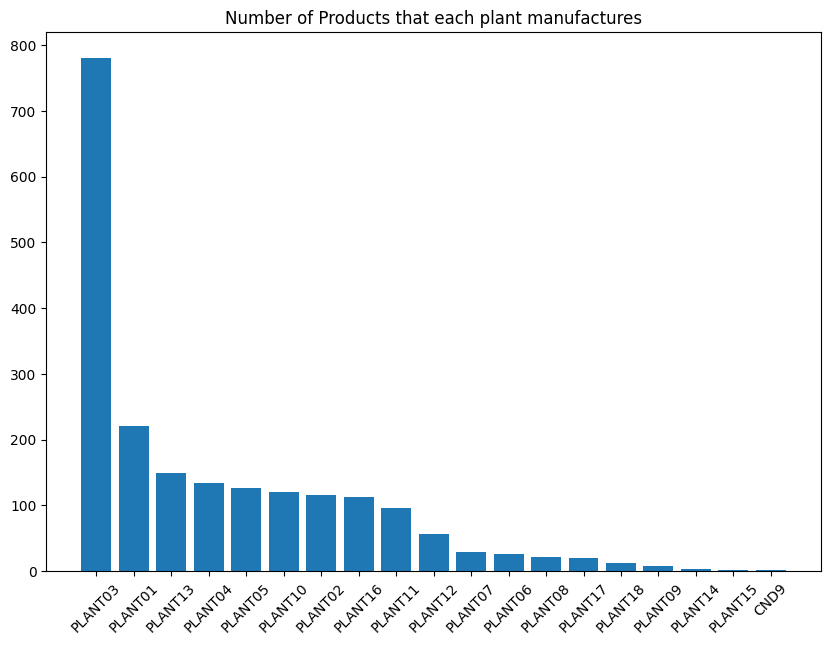

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(products_plants["Plant_Code"].value_counts())
ax.bar(plant_counts.index, plant_counts.values.flatten())
plt.title("Number of Products that each plant manufactures")
plt.show()

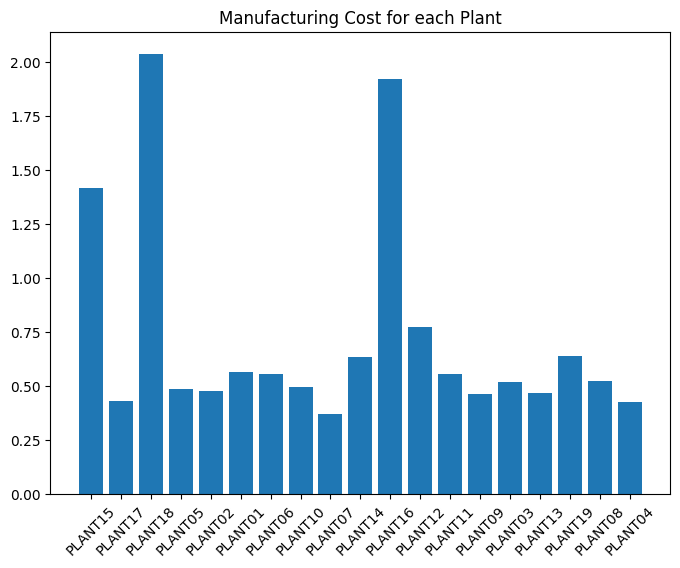

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
plt.xticks(rotation=45)
ax.bar(wh_cost.index, wh_cost["Cost/unit"])
plt.title("Manufacturing Cost for each Plant")
plt.show()